## Prédiction de la consommation
Utilisation d'un gradient boosting regressor :
- http://scikit-learn.org/stable/auto_examples/applications/plot_model_complexity_influence.html#sphx-glr-auto-examples-applications-plot-model-complexity-influence-py


https://transparency.entsoe.eu/

https://www.swissgrid.ch/swissgrid/en/home/experts/topics/energy_data_ch.html

In [182]:
from mpl_toolkits.axes_grid1.parasite_axes import host_subplot
from mpl_toolkits.axisartist.axislines import Axes
from scipy.sparse.csr import csr_matrix

from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.svm.classes import NuSVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.metrics import hamming_loss



import locale, time
# locale.setlocale(locale.LC_TIME, "fr_FR".encode('ascii'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# from matplotlib import rc
# from __future__ import unicode_literals
import numpy as np
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
# rc('font',**{'family':'serif','serif':['Times']})

%matplotlib inline



# données météo 
bale=pd.read_csv('dataset/history_export_2016-12-03T18-03-27.csv', sep=";", skiprows=11)
bale["date"]=pd.to_datetime({
        'year': bale["Year"],
        'month': bale["Month"],
        'day': bale["Day"],
        'hour': bale["Hour"],
                    })
bale = bale.set_index(['date'])
bale["radiation"] = bale["Shortwave Radiation - backwards"]/1000



# données de consommation
df_14=pd.read_csv('dataset/conso_bale_2014.csv', sep=",") # attention les données de 2014 sont moins fiables : toute la Suisse
df_14['kWh']/=df_14['kWh'].sum()
df_15=pd.read_csv('dataset/conso_bale_2015.csv', sep=",")
df_15['kWh']/=df_15['kWh'].sum()
df_16=pd.read_csv('dataset/conso_bale_2016.csv', sep=",")
df_16['kWh']/=df_16['kWh'].sum()
df = pd.concat([df_14, df_15, df_16])
df["date"]=pd.to_datetime(df["date"])
df = df.set_index(['date'])
consoPerso = 20000 # consommation annuelle kWh d'un foyer
# 20000 pour un foyer : http://www.monenergie.net/consommation-moyenne-d-electricite-d-une-maison.php
df['kWh']*=consoPerso
df['kWh'].loc[df.index.year == 2016]*=float(len(df[df.index.year == 2016]))/len(df[df.index.year == 2015])
df = df.resample('60T').sum()
df = df[~df.index.duplicated()] # resoud les passages aux heures d'hiver et d'ete
df = df.fillna(method='ffill')
bale["consommation"] =  df["kWh"]

# Index (intersection of df and bale)
bale = bale.reindex(bale.index.intersection(df.index))
hour = bale.index.hour
month = bale.index.month
HC = ((hour >= 2) & (hour < 7)) | ((hour >= 14) & (hour < 17))
HP =  ((hour >= 7) & (hour < 14)) | (hour >= 17) | (hour < 2)

# prix_achat = np.array([0.129, 0.105])
prix_achat = np.array([0.15600,0.12700 ])
# evolution = np.array([2.3, 0, 0, 0 ,0 ,0, 0, 5, 0,0,0,0])
# evolution = np.array([1/3, 1, 1, 1, 1, 1,   1,1,1,1/2.5,1, \
#                      1, 1, 1, ,1,1,1   1/2.5,1,1,1,1,1, \
#                      1, 1, 1, ,1,1,1   -1/.5,1,1,1,1,1])
# inflation = (1+evolution/100).cumprod()
bale["inflation"] = pd.Series(1, df.index)
# df["Inflation"].loc[(df.index.day == 1) & (df.index.hour == 0)] = inflation
# df["Inflation"] = df["Inflation"].fillna(method='ffill')
abonnement = 117.5
abonnement_heure = abonnement/365.25/24
prix_hc = prix_achat[1]* bale["inflation"] +abonnement_heure
prix_hp = prix_achat[0]* bale["inflation"] +abonnement_heure
prix = prix_hp
prix.loc[(hour >= 2) & (hour < 7)] = prix_hc[(hour >= 2) & (hour < 7)]
prix.loc[(hour >= 14) & (hour < 17)] = prix_hc[(hour >= 14) & (hour < 17)]
bale["depense"] = bale["consommation"].copy()
bale["depense"].loc[HC] *= prix_hc
bale["depense"].loc[HP] *= prix_hp
prix_pv = 0.1272 - abonnement_heure
prix_eolien = 0.082 - abonnement_heure 



In [42]:
# initialize random generator
np.random.seed(0)

def benchmark_influence(conf):
    """
    Benchmark influence of :changing_param: on both MSE and latency.
    """
    prediction_times = []
    prediction_powers = []
    complexities = []
    for param_value in conf['changing_param_values']:
        conf['tuned_params'][conf['changing_param']] = param_value
        estimator = conf['estimator'](**conf['tuned_params'])
#         print("Benchmarking %s" % estimator)
        estimator.fit(conf['data']['X_train'], conf['data']['y_train'])
        conf['postfit_hook'](estimator)
        complexity = conf['complexity_computer'](estimator)
        complexities.append(complexity)
        start_time = time.time()
        for _ in range(conf['n_samples']):
            y_pred = estimator.predict(conf['data']['X_test'])
        elapsed_time = (time.time() - start_time) / float(conf['n_samples'])
        prediction_times.append(elapsed_time)
        pred_score = conf['prediction_performance_computer'](
            conf['data']['y_test'], y_pred)
        prediction_powers.append(pred_score)
#         print("Complexity: %d | %s: %.4f | Pred. Time: %fs\n" % (
#             complexity, conf['prediction_performance_label'], pred_score,
#             elapsed_time))
    return prediction_powers, prediction_times, complexities, y_pred


def plot_influence(conf, mse_values, prediction_times, complexities):
    """
    Plot influence of model complexity on both accuracy and latency.
    """
    plt.figure(figsize=(12, 6))
    host = host_subplot(111, axes_class=Axes)
    plt.subplots_adjust(right=0.75)
    par1 = host.twinx()
    host.set_xlabel('Model Complexity (%s)' % conf['complexity_label'])
    y1_label = conf['prediction_performance_label']
    y2_label = "Time (s)"
    host.set_ylabel(y1_label)
    par1.set_ylabel(y2_label)
    p1, = host.plot(complexities, mse_values, 'b-', label="prediction error")
    p2, = par1.plot(complexities, prediction_times, 'r-',
                    label="latency")
    host.legend(loc='upper right')
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    plt.title('Influence of Model Complexity - %s' % conf['estimator'].__name__)
    plt.show()


def _count_nonzero_coefficients(estimator):
    a = estimator.coef_.toarray()
    return np.count_nonzero(a)

## Entrainement avec le jour précédent

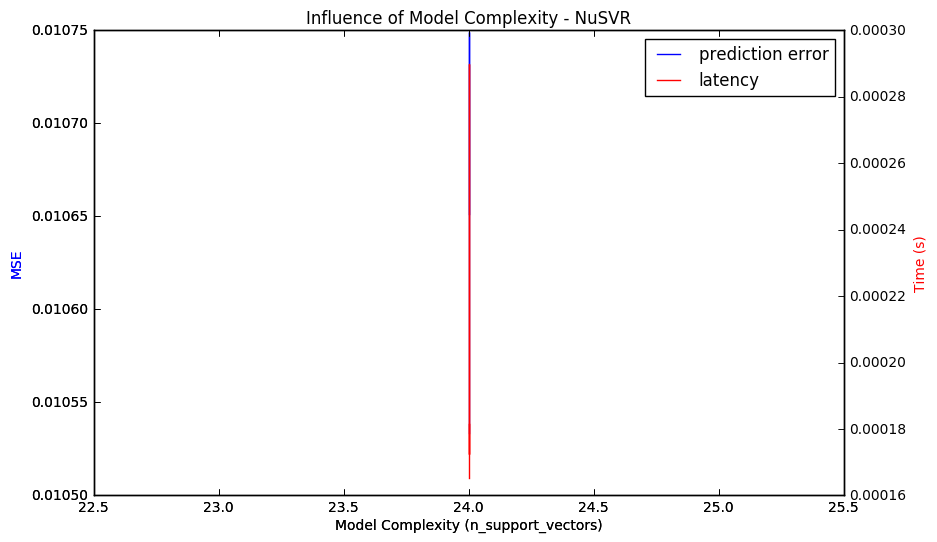

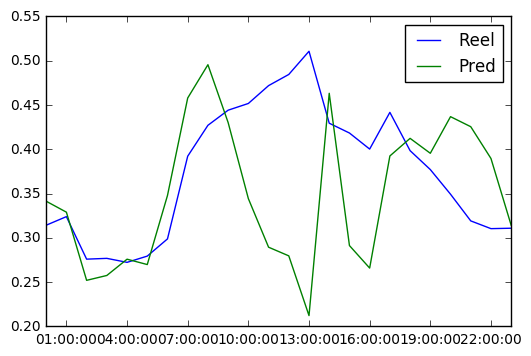

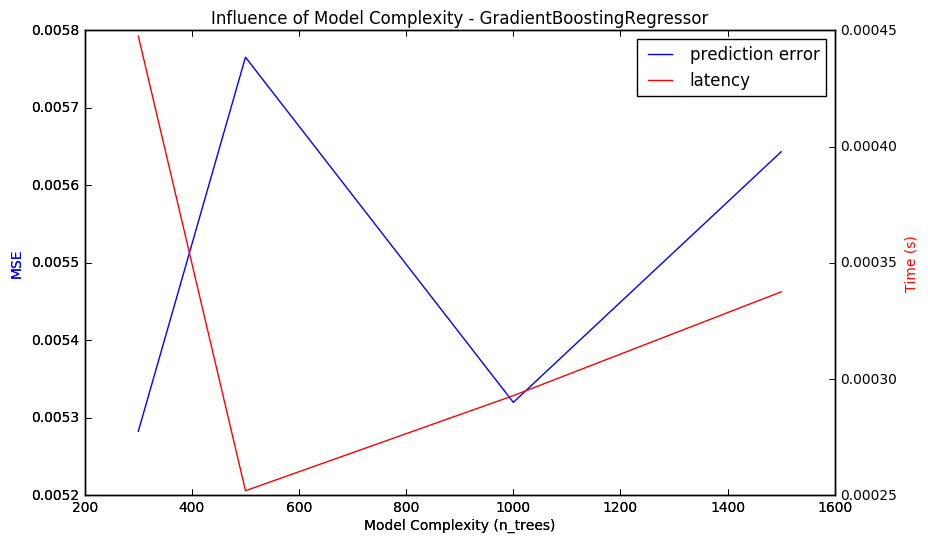

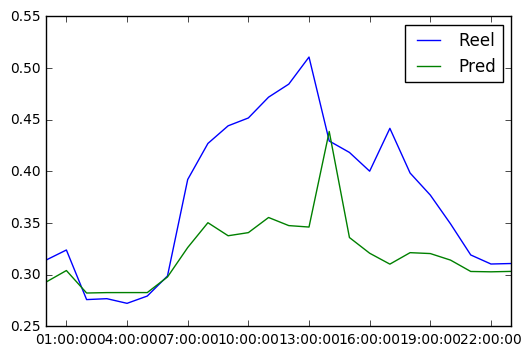

In [104]:
mai6 = (bale.index.day == 6) & (bale.index.month == 5) & (bale.index.year == 2015)
mai = (bale.index.month == 5)  & (bale.index.year == 2015)
mai7 = (bale.index.day == 7) & (bale.index.month == 5)  & (bale.index.year == 2015)

view = bale[['Temperature', "Shortwave Radiation - backwards", 'Wind Gust', 'Wind speed', \
             'Relative humidity', 'Mean Sea Level Pressure', 'Total Precipitation', \
             'Snowfall amount', 'Total cloud cover', 'High cloud cover', \
            'Low cloud cover', 'Shortwave Radiation - backwards', 'Wind speed', 'Wind direction', 'Hour']]
y_train = bale["depense"][mai6]
y_test = bale["depense"][mai7]
X_train = view[mai6]
X_test = view[mai7]

regression_1day = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train,
            'y_test': y_test}


configurations = [
    {'estimator': NuSVR,
     'tuned_params': {'C': 1e3, 'gamma': 2 ** -15},
     'changing_param': 'nu',
     'changing_param_values': [0.1, 0.25, 0.5, 0.75, 0.9],
     'complexity_label': 'n_support_vectors',
     'complexity_computer': lambda x: len(x.support_vectors_),
     'data': regression_1day,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
    {'estimator': GradientBoostingRegressor,
     'tuned_params': {'loss': 'ls'},
     'changing_param': 'n_estimators',
     'changing_param_values': [300, 500, 1000, 1500],
     'complexity_label': 'n_trees',
     'complexity_computer': lambda x: x.n_estimators,
     'data': regression_1day,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
]

for conf in configurations:
    prediction_performances, prediction_times, complexities, y_pred = \
        benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times,
                   complexities)
    plt.figure()
    plt.plot(y_test.index, y_test.values, label="Reel")
    plt.plot(y_test.index, y_pred, label="Pred")
    plt.legend()
    plt.show() 

## Entrainement sur le mois précédent

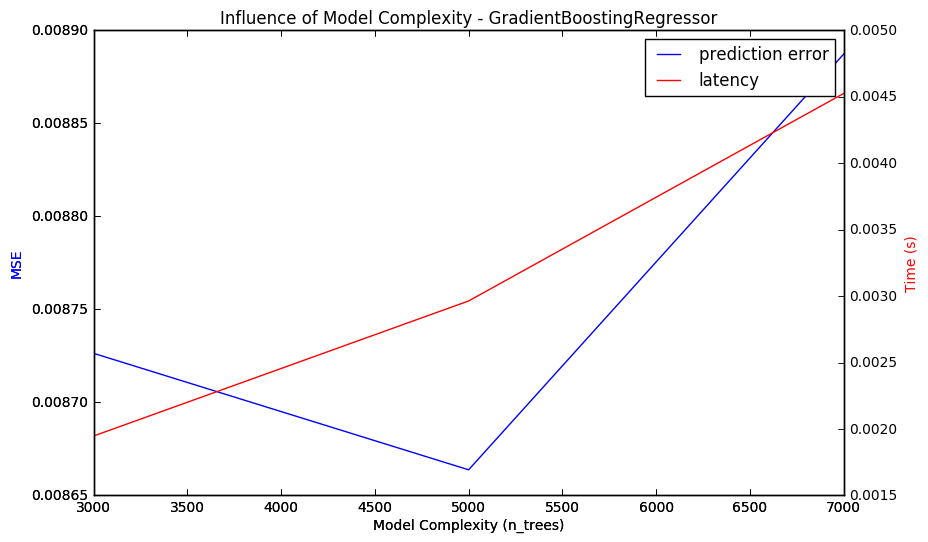

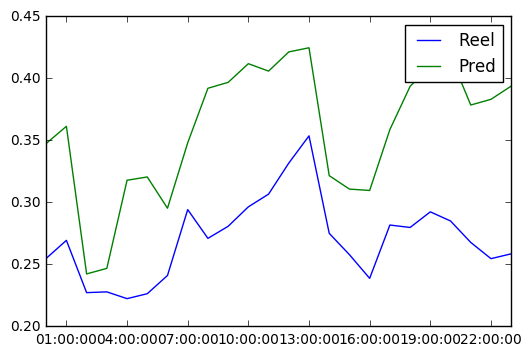

In [150]:
# mai6 = (bale.index.day == 6) & (bale.index.month == 5) & (bale.index.year == 2015)
# avril = (bale.index.month <= 4) & (bale.index.year == 2015)
# mai7 = (bale.index.day == 7) & (bale.index.month == 5) & (bale.index.year == 2015)
# mai1 = (bale.index.day == 1) & (bale.index.month == 5) & (bale.index.year == 2015)
a2015 = (bale.index.year == 2015) #& (bale.index.month == 3)  & (bale.index.day <= 29)
a2016 = (bale.index.year == 2016)

view = bale[['Temperature', "Shortwave Radiation - backwards", 'Wind Gust', 'Wind speed', \
             'Relative humidity', 'Mean Sea Level Pressure', 'Total Precipitation', \
             'Snowfall amount', 'Total cloud cover', 'High cloud cover', \
            'Low cloud cover', 'Shortwave Radiation - backwards', 'Wind speed', 'Wind direction', 'Hour']]

y_train2 = bale["depense"][a2015]
y_test2 = bale["depense"][a2016]
X_train2 = view[a2015]
X_test2 = view[a2016]

regression_1month = {'X_train': X_train2, 'X_test': X_test2, 'y_train': y_train2,
            'y_test': y_test2}

configurations = [
#     {'estimator': NuSVR,
#      'tuned_params': {'C': 1e3, 'gamma': 2 ** -15},
#      'changing_param': 'nu',
#      'changing_param_values': [0.1, 0.25, 0.5, 0.75, 0.9],
#      'complexity_label': 'n_support_vectors',
#      'complexity_computer': lambda x: len(x.support_vectors_),
#      'data': regression_1month,
#      'postfit_hook': lambda x: x,
#      'prediction_performance_computer': mean_squared_error,
#      'prediction_performance_label': 'MSE',
#      'n_samples': 30},
    {'estimator': GradientBoostingRegressor,
     'tuned_params': {'loss': 'ls'},
     'changing_param': 'n_estimators',
     'changing_param_values': [ 3000,  5000, 7000],
     'complexity_label': 'n_trees',
     'complexity_computer': lambda x: x.n_estimators,
     'data': regression_1month,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE',
     'n_samples': 30},
]

for conf in configurations:
    prediction_performances, prediction_times, complexities, y_pred = \
        benchmark_influence(conf)
    plot_influence(conf, prediction_performances, prediction_times,
                   complexities)
    plt.figure()
    plt.plot(y_test.index, y_test.values, label="Reel")
    plt.plot(y_test.index, y_pred, label="Pred")
    plt.legend()
    plt.show() 


## Conclusion:
il faut mieux utiliser le GBR avec 5000 arbres et 1 mois d'entrainement



Time execution: 0.226998
MSE error: 0.003474


NameError: name 'y_pred2' is not defined

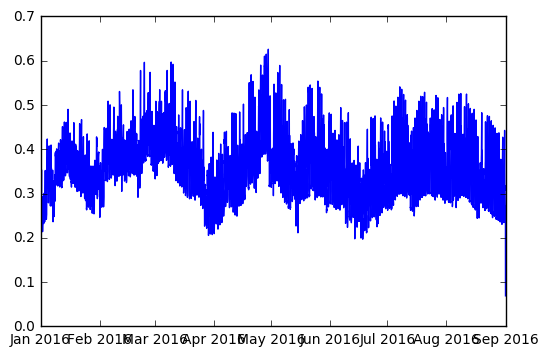

In [183]:
a2015 = (bale.index.year == 2015) #& (bale.index.month == 3)  & (bale.index.day <= 29)
a2016 = (bale.index.year == 2016)

view = bale[['Temperature', "Shortwave Radiation - backwards", 'Wind Gust', 'Wind speed', \
             'Relative humidity', 'Mean Sea Level Pressure', 'Total Precipitation', \
             'Snowfall amount', 'Total cloud cover', 'High cloud cover', \
            'Low cloud cover', 'Shortwave Radiation - backwards', 'Wind speed', 'Wind direction', 'Hour']]

y_train2 = bale["depense"][a2015]
y_test2 = bale["depense"][a2016]
X_train2 = view[a2015]
X_test2 = view[a2016]

regression_1month = {'X_train': X_train2, 'X_test': X_test2, 'y_train': y_train2,
            'y_test': y_test2}

conf = {'estimator': GradientBoostingRegressor,
     'tuned_params': {'loss': 'ls'},
     'changing_param': 'n_estimators',
     'changing_param_value': 3000,
     'complexity_label': 'n_trees',
     'complexity_computer': lambda x: x.n_estimators,
     'data': regression_1month,
     'postfit_hook': lambda x: x,
     'prediction_performance_computer': mean_squared_error,
     'prediction_performance_label': 'MSE'
    }

conf['tuned_params'][conf['changing_param']] = conf['changing_param_value']
estimator = conf['estimator'](**conf['tuned_params'])
estimator.fit(conf['data']['X_train'], conf['data']['y_train'])
conf['postfit_hook'](estimator)
start_time = time.time()
y_pred = estimator.predict(conf['data']['X_test'])
elapsed_time = (time.time() - start_time)
print("Time execution: %f" % elapsed_time)
pred_score = conf['prediction_performance_computer'](
conf['data']['y_test'], y_pred)
print("MSE error: %f" % pred_score)
    
plt.figure()
plt.plot(y_test2.index, y_test2.values, label="Reel")
plt.plot(y_test2.index, y_pred, label="Pred")
plt.legend()
plt.show() 

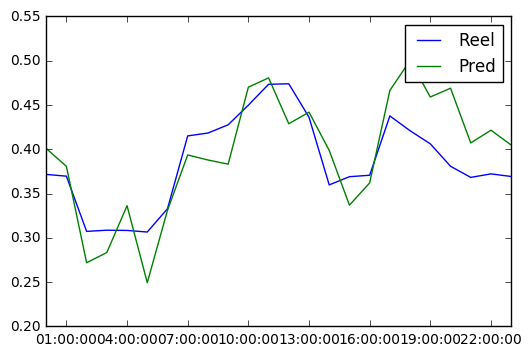

In [192]:
rdm_day = (bale.index.day == 23) & (bale.index.month == 5) & (bale.index.year == 2016)
plt.figure()
plt.plot(bale["depense"][rdm_day].index, bale["depense"][rdm_day].values, label="Reel")
# y_test2.plot()
# bale["depense"].plot()
pred = estimator.predict(view[rdm_day])
plt.plot(view[rdm_day].index, pred, label="Pred")
plt.legend()
plt.show() 
# X_test2.plot()
# print estimator.predict(X_test2)

